In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#Transforms
transformer=transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    torchvision.transforms.Grayscale(num_output_channels=1)
])

#dataloader
train_path =  r"C:\Dataset\Train_set"
test_path = r"C:\Dataset\Test_set"
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

cuda
['L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others']


In [2]:
import torch.nn as nn

class MobileNetV1(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(input_channel, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7)
        )
        self.fc = nn.Linear(1024, n_classes)

        self.model.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def init_weights(self, layer):
        if type(layer) == nn.Conv2d:
            nn.init.kaiming_normal_(layer.weight, mode='fan_out')
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, std=1e-3)
        if type(layer) == nn.BatchNorm2d:
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x
            

In [3]:
model=MobileNetV1(input_channel=1, n_classes=23).to(device)
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)

77846 23666


In [4]:
import torch
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [5]:
y_pred = []
y_true = []
train_losses = []
test_accuracies = []
best_accuracy= 0.0
test_accuracy=0.0
train_accuracy=0.0
train_loss=0.0

In [6]:
def train_test(start_epochs, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred):
    #Model training and saving best model

    for epoch in range(start_epochs, num_epochs+1):

        #Evaluation and training on training dataset
        model.train()

        for i, (images,labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            optimizer.zero_grad()

            outputs=model(images)
            loss=loss_function(outputs,labels)
            loss.backward()
            optimizer.step()

            train_loss+= loss.cpu().data*images.size(0)
            _,prediction=torch.max(outputs.data,1)

            train_accuracy+=int(torch.sum(prediction==labels.data))

        train_accuracy=train_accuracy/train_count
        train_loss=train_loss/train_count

        # Evaluation on testing dataset
        model.eval()

        for i, (images,labels) in enumerate(test_loader):
            if torch.cuda.is_available():
                images=Variable(images.cuda())
                labels=Variable(labels.cuda())

            outputs=model(images)
            _,prediction=torch.max(outputs.data,1)
            test_accuracy+=int(torch.sum(prediction==labels.data))

            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction

            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

        test_accuracy=test_accuracy/test_count

        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
        
        train_losses.append(train_loss.item())
        test_accuracies.append(test_accuracy)
        checkpoint = {
                'start_epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_accuracy': best_accuracy,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_loss': train_loss,
                'train_losses':train_losses,
                'test_accuracies': test_accuracies,
                'y_true': y_true,
                'y_pred': y_pred
        }
        save_ckp(checkpoint, False, checkpoint_path='current_checkpoint_mobilenetv1.pt', best_model_path='best_checkpoint_mobilenetv1.model')
        #Save the best model
        if test_accuracy>best_accuracy:
            torch.save(model.state_dict(),'best_checkpoint_mobilenetv1.model')
            best_accuracy=test_accuracy
            checkpoint['best_accuracy']=best_accuracy
            save_ckp(checkpoint, True, checkpoint_path='current_checkpoint_mobilenetv1.pt', best_model_path='best_checkpoint_mobilenetv1.model')

In [7]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    best_accuracy = checkpoint['best_accuracy']
    train_accuracy = checkpoint['train_accuracy']
    test_accuracy = checkpoint['test_accuracy']
    train_loss = checkpoint['train_loss']    
    train_losses = checkpoint['train_losses']    
    test_accuracies = checkpoint['test_accuracies']   
    start_epoch = checkpoint['start_epoch']
    y_true = checkpoint['y_true']
    y_pred = checkpoint['y_pred']
    return model, optimizer,start_epoch,best_accuracy, train_accuracy,test_accuracy,train_loss.item(),train_losses,test_accuracies,y_true,y_pred

In [8]:
def conf_matrix(y_true,y_pred):
     # constant for classes
    classes = ('L4', 'day1', 'day10', 'day11', 'day12', 'day13', 'day14', 'day15', 'day16', 'day17', 'day18', 'day19', 'day2', 'day20', 'day21', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9', 'others')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')

In [9]:
def learn_curve_train_losses(train_losses):
    plt.plot(train_losses,'-o')
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train'])
    plt.title('Train Losses Per Epoch')

    plt.show()
    
def learn_curve_test_accuracies(test_accuracies):
    plt.plot(test_accuracies,'-r')
    plt.xlabel('epoch')
    plt.ylabel('test_accuracy')
    plt.legend(['Test Accuracy'])
    plt.title('Test Accuracy Per Epoch')
    plt.show()


In [10]:
num_epochs = 40

import os.path

if os.path.isfile("current_checkpoint_mobilenetv1.pt"):
    model=MobileNetV1(input_channel=1,n_classes=23).to(device)
    ckp_path = "current_checkpoint_mobilenetv1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)


Epoch: 1 Train Loss: tensor(2.3536) Train Accuracy: 0.23446291395832797 Test Accuracy: 0.2964590551846531
Epoch: 2 Train Loss: tensor(1.4000) Train Accuracy: 0.5461068579363609 Test Accuracy: 0.5529576801764212
Epoch: 3 Train Loss: tensor(0.9035) Train Accuracy: 0.7094975478105224 Test Accuracy: 0.6069700396214053
Epoch: 4 Train Loss: tensor(0.6896) Train Accuracy: 0.7787774516037794 Test Accuracy: 0.5358576426113252
Epoch: 5 Train Loss: tensor(0.5716) Train Accuracy: 0.8167250568744907 Test Accuracy: 0.6711119689699405
Epoch: 6 Train Loss: tensor(0.4857) Train Accuracy: 0.8442799466261193 Test Accuracy: 0.6556102050185485
Epoch: 7 Train Loss: tensor(0.4317) Train Accuracy: 0.8617506908504821 Test Accuracy: 0.6949909410210858
Epoch: 8 Train Loss: tensor(0.3761) Train Accuracy: 0.8787845457787279 Test Accuracy: 0.6735272116513573
Epoch: 9 Train Loss: tensor(0.3426) Train Accuracy: 0.8899092925075891 Test Accuracy: 0.6960058111726379
Epoch: 10 Train Loss: tensor(0.3125) Train Accuracy: 0

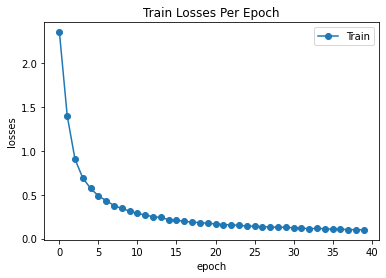

In [11]:
learn_curve_train_losses(train_losses)

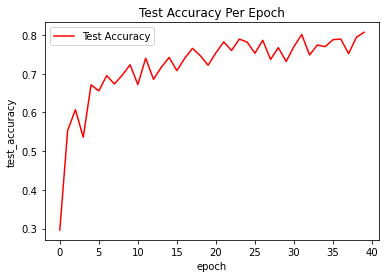

In [12]:
learn_curve_test_accuracies(test_accuracies)

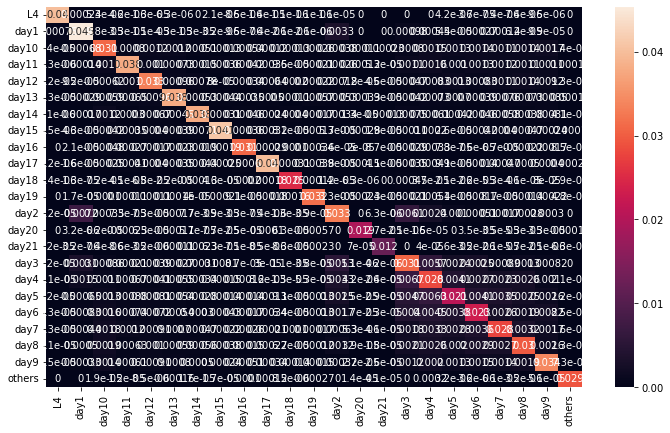

In [13]:
conf_matrix(y_true,y_pred)

In [14]:
num_epochs = 50

import os.path

if os.path.isfile("current_checkpoint_mobilenetv1.pt"):
    model=MobileNetV1(input_channel=1,n_classes=23).to(device)
    ckp_path = "current_checkpoint_mobilenetv1.pt"
    model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
    train_test(start_epoch, best_accuracy,train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)
else:
    train_test(1,best_accuracy, train_accuracy,test_accuracy,train_loss, train_losses, test_accuracies,y_true,y_pred)


Epoch: 41 Train Loss: tensor(0.0686) Train Accuracy: 0.9784570621862311 Test Accuracy: 0.8258179250411941
Epoch: 42 Train Loss: tensor(0.0689) Train Accuracy: 0.9790352549528837 Test Accuracy: 0.8292836059293941
Epoch: 43 Train Loss: tensor(0.0700) Train Accuracy: 0.9786884237501599 Test Accuracy: 0.8259456301701145
Epoch: 44 Train Loss: tensor(0.0694) Train Accuracy: 0.9788554156722729 Test Accuracy: 0.8279737152721276
Epoch: 45 Train Loss: tensor(0.0693) Train Accuracy: 0.9779176689285983 Test Accuracy: 0.8266216502034678
Epoch: 46 Train Loss: tensor(0.0682) Train Accuracy: 0.9792536279021264 Test Accuracy: 0.8300442246957745
Epoch: 47 Train Loss: tensor(0.0697) Train Accuracy: 0.9780332869206882 Test Accuracy: 0.8294528033560675
Epoch: 48 Train Loss: tensor(0.0692) Train Accuracy: 0.9781360382458563 Test Accuracy: 0.8273822975071139
Epoch: 49 Train Loss: tensor(0.0686) Train Accuracy: 0.9782901900680606 Test Accuracy: 0.8269596629044835
Epoch: 50 Train Loss: tensor(0.0698) Train Acc

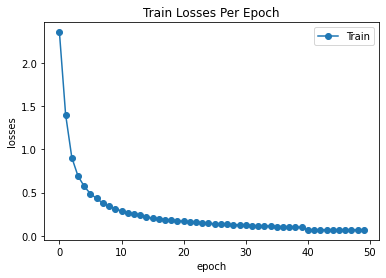

In [15]:
learn_curve_train_losses(train_losses)

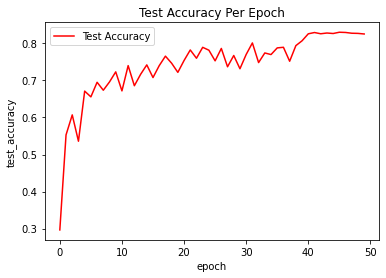

In [16]:
learn_curve_test_accuracies(test_accuracies)

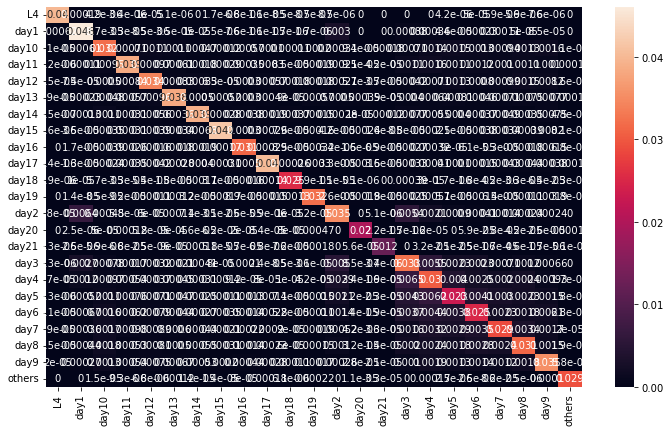

In [17]:
conf_matrix(y_true,y_pred)

In [10]:
ckp_path = "current_checkpoint_mobilenetv1.pt"
model, optimizer, start_epoch, best_accuracy, train_accuracy,test_accuracy,train_loss,train_losses,test_accuracies,y_true,y_pred  = load_ckp(ckp_path, model, optimizer)
print(best_accuracy)

0.8300442246957745
